In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
path = '/Users/gert-janboth/Documents/flyTracker/data/movies/short_test.mp4'

In [3]:
cap = cv2.VideoCapture(path)

In [4]:
length = cap.get(cv2.CAP_PROP_FRAME_COUNT) # works only on mp4's
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps    = cap.get(cv2.CAP_PROP_FPS)

print(length, fps, width, height)

120.0 25.0 1280.0 1080.0


In [5]:
ret, frame = cap.read()

In [6]:
test_frame = frame

# Reworking localization

In [8]:
frame = test_frame

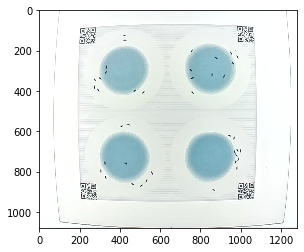

In [9]:
plt.imshow(frame)

In [10]:
# Step 1 - Preprocssing: turning into grayscale
# TO DO: might be faster to do this with ffmpeg?

frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

(1080, 1280)


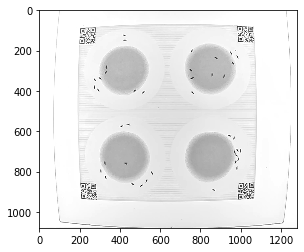

In [11]:
print(frame_grayscale.shape)
plt.imshow(frame_grayscale, cmap='gray')

In [12]:
# Step 2 - thresholding
# TO DO: include automatic minimum threshold

threshold = 127
ret, thresholded_frame = cv2.threshold(frame_grayscale, threshold, 255, cv2.THRESH_BINARY_INV)

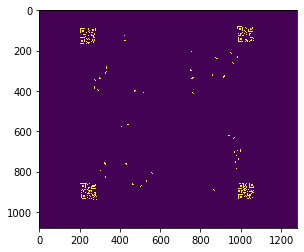

In [13]:
plt.imshow(thresholded_frame)

In [14]:
#Step 3 - Post Processing: Dilating and blurring
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

processed_frame = cv2.dilate(thresholded_frame, kernel)
processed_frame = cv2.medianBlur(processed_frame, 3)

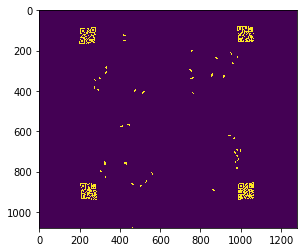

In [15]:
plt.imshow(processed_frame)

In [16]:
# Step 4 - removing QR codes
# TO DO: make automatic

processed_frame[:200, :300] = 0 # upper left corner
processed_frame[-250:, :300] = 0 # lower left corner
processed_frame[-250:, -300:] = 0 # lower right corner
processed_frame[:200, -300:] = 0 # lower right corner

#any weird shit outside of the roi
processed_frame[:70, :] = 0
processed_frame[-120:, :] = 0
processed_frame[:, :180] = 0
processed_frame[:, -200:] = 0

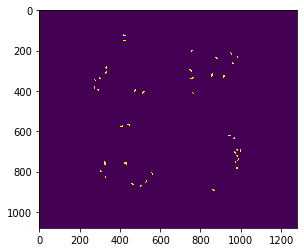

In [17]:
plt.imshow(processed_frame)

In [18]:
# Step 5 - finding contours
# Maybe fit ellipses instead of finding contours?
contours = cv2.findContours(processed_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

In [19]:
print(len(contours)) # 10 per arena = 40 in total

40


In [20]:
contour = contours[0]

In [24]:
# Step 6 - iterating over flies
# Get rectangular bounding boxes (why two?)
bbox = cv2.minAreaRect(contour) 
x, y, w, h = cv2.boundingRect(contour)

# Check if perimeter isnt too long
max_perimeter = 200
perimeter = cv2.arcLength(contour, True)
if perimeter > max_perimeter:
    print('Perimeter too long. Skipping.')
    #continue
    
# Get area and coordinates of bounding box
area = cv2.contourArea(contour)
bbox_coors = cv2.boxPoints(bbox).astype(np.int)

# Try and fit an ellipse
if contour.shape[0] >= 5:
    ellipse = cv2.fitEllipse(contour)
else:
    ellipse = [(-1, -1), (-1, -1), -1]

# Finding pixels of fly
mask = cv2.fillPoly(np.zeros_like(processed_frame), [contour], 1) # oof this is a massive array for a single fly...
pixels = cv2.findNonZero(mask[y:(y + h), x:(x + w)]).astype(np.float32)
n_pixels = pixels.shape[0]

# WTF is happening here?
centroids = []
max_flies_by_cluster = 5
kmeans_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
for n in range(2, max_flies_by_cluster + 1): #iterating over what exactly?
    if n_pixels <= n: # what does the number of pixels have to do with number of flies?
        cx = ((bbox_coors[0, 0] + bbox_coors[1, 0] + bbox_coors[2, 0] + bbox_coors[3, 0]) / 4) # why / 4 ?
        cy = ((bbox_coors[0, 1] + bbox_coors[1, 1] + bbox_coors[2, 1] + bbox_coors[3, 1]) / 4)
        for num in range(n):
            centroids.append(int(cx))
            centroids.append(int(cy))
            centroids.append(n)
    else:
        ret, label, center = cv2.kmeans(pixels, n, None, kmeans_criteria, 10, flags)
        for num in range(n):
            centroids.append(int(float(center[num][0]) + x))
            centroids.append(int(float(center[num][1]) + y))
            centroids.append(np.sum(label == num))

# centres of the contour and angle of bbox
# in original code there's a bug in the angle, its converted to degrees twice (once here, once in current_plot).
# We only do it here.
cx = np.mean(pixels, 0)[0, 0] + x
cy = np.mean(pixels, 0)[0, 1] + y
angle = np.arctan((bbox_coors[0, 1]-bbox_coors[1, 1]) / (bbox_coors[0, 0]-bbox_coors[1, 0]))*180/np.pi 

# Collecting output
centroids = np.array(centroids, dtype=np.float32).reshape(1, 1, -1)
flies = np.array([[[cx, cy, angle, area, ellipse[0][0], ellipse[0][1], ellipse[1][0], ellipse[1][1], ellipse[2]]]], dtype=np.float32)
flies = np.concatenate((flies , centroids), axis=2)


# Testing function

In [9]:
from flytracker.localise import localise_flies

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
flies = localise_flies(frame)

In [13]:
flies.shape

(1, 1, 51)

more flies than there are, but it works.